In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import time
import random
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence


c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Dell\Desktop\projects\pytorch_projects\.venv\Lib\site-packages\torchtext\data\__init

In [2]:
RANDOM_SEED=42
MAX_VOCAB=20000
LEARNING_RATE=0.005
BATCH_SIZE=128
EMBEDDING_DIM=128
HIDDEN_DIM=256
NUM_CLASSES=2
NUM_EPOCHS=15
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

Using device: cuda


In [3]:
tokenizer=get_tokenizer('spacy',language='en_core_web_sm')

In [4]:
def yeild_tokens(data_itr):
    for _,text in data_itr:
        yield tokenizer(text)

In [5]:
class IMDBCSVDataset(Dataset):
    def __init__(self,csv_data):
        self.data=pd.read_csv(csv_data)
        self.data['sentiment']=self.data['sentiment'].map({'positive':1,'negative':0})
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        label=self.data.iloc[idx]['sentiment']
        text=self.data.iloc[idx]['review']
        return label,text

In [6]:
dataset=IMDBCSVDataset('IMDB Dataset.csv')
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[0.8,0.2])
train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[0.85,0.15])
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 34000
Validation dataset size: 6000
Test dataset size: 10000


In [7]:
vocab=build_vocab_from_iterator(yeild_tokens(train_dataset),max_tokens=MAX_VOCAB,specials=['<unk>','<pad>'])
vocab.set_default_index(vocab['<unk>'])
print(f"Vocab size: {len(vocab)}")

Vocab size: 20000


In [8]:
def text_pipeline(x):
    tokens=tokenizer(x)
    indexed_token=[vocab[token] for token in tokens]
    return torch.tensor(indexed_token,dtype=torch.long)
def collate_batch(batch):
    label_list=[]
    review_list=[]
    for (_label,_review) in batch:
        label_list.append(_label)
        processed_review=text_pipeline(_review)
        review_list.append(processed_review)
    label_list=torch.tensor(label_list,dtype=torch.long)
    review_list=pad_sequence(review_list,batch_first=True,padding_value=vocab['<pad>'])
    return review_list,label_list

In [9]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_batch)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch)

In [10]:
class GRU(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_classes):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=vocab['<pad>'])
        self.gru=nn.GRU(embedding_dim,hidden_dim,batch_first=True)
        self.fc=nn.Linear(hidden_dim,num_classes)
        
    def forward(self,x):
        embedded=self.embedding(x)
        _,hidden=self.gru(embedded)
        out=self.fc(hidden[-1])
        return out

In [11]:
def compute_acc(model,data_loader):
    model.eval()
    correct=0
    total=0
    for i,(features,labels) in enumerate(data_loader):
        features,labels=features.to(DEVICE),labels.to(DEVICE)
        outputs=model(features)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    return (correct*100)/total

In [12]:
torch.manual_seed(RANDOM_SEED)
model=GRU(len(vocab),EMBEDDING_DIM,HIDDEN_DIM,NUM_CLASSES).to(DEVICE)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
train_accs=[]
val_accs=[]

In [13]:
start=time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for i,(features,labels) in enumerate(train_loader):
        features,labels=features.to(DEVICE),labels.to(DEVICE)
        outputs=model(features)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc=compute_acc(model,train_loader)
    val_acc=compute_acc(model,val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] : \n Time Elapsed: {((time.time()-start)/60.00):.2f} mins, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/15] : 
 Time Elapsed: 3.17 mins, Train Acc: 50.06%, Val Acc: 50.75%
Epoch [2/15] : 
 Time Elapsed: 6.15 mins, Train Acc: 58.86%, Val Acc: 56.25%
Epoch [3/15] : 
 Time Elapsed: 9.10 mins, Train Acc: 64.84%, Val Acc: 60.08%
Epoch [4/15] : 
 Time Elapsed: 12.00 mins, Train Acc: 76.06%, Val Acc: 66.72%
Epoch [5/15] : 
 Time Elapsed: 15.02 mins, Train Acc: 80.92%, Val Acc: 69.37%
Epoch [6/15] : 
 Time Elapsed: 17.96 mins, Train Acc: 81.92%, Val Acc: 69.17%
Epoch [7/15] : 
 Time Elapsed: 21.02 mins, Train Acc: 87.32%, Val Acc: 72.25%
Epoch [8/15] : 
 Time Elapsed: 23.99 mins, Train Acc: 89.16%, Val Acc: 73.58%
Epoch [9/15] : 
 Time Elapsed: 27.01 mins, Train Acc: 91.20%, Val Acc: 73.68%
Epoch [10/15] : 
 Time Elapsed: 30.01 mins, Train Acc: 92.47%, Val Acc: 74.13%
Epoch [11/15] : 
 Time Elapsed: 38.48 mins, Train Acc: 93.70%, Val Acc: 74.48%
Epoch [12/15] : 
 Time Elapsed: 41.63 mins, Train Acc: 94.78%, Val Acc: 74.62%
Epoch [13/15] : 
 Time Elapsed: 44.80 mins, Train Acc: 95.70%, V

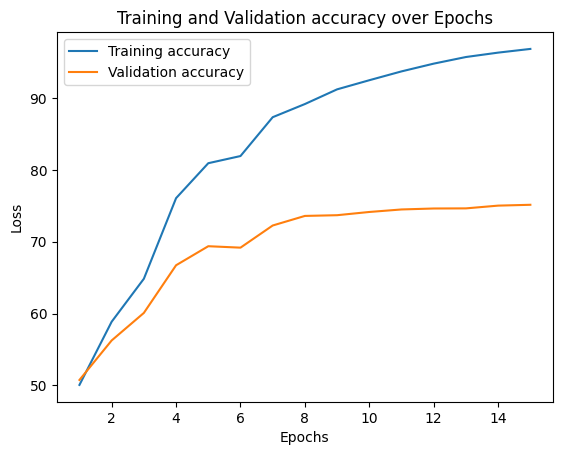

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label='Validation accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation accuracy over Epochs')
plt.legend()
plt.show()

In [16]:
compute_acc(model,test_loader)

74.39